# FAIR Risk Modelling

This notebook attempts a simplistic implementation of the FAIR model. The Factor Analysis of Information Risk (FAIR) framework has an ontology as a key element. 

<img src="img/FAIR.png"/>


I use this model to build a simplistic model of risk. Since frequency and magnitude are not fixed, but instead are random variables, I use some probabilistic modeling to explore it.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from statistics import NormalDist

from sklearn.preprocessing import scale
import math
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pymc3 as pm
import arviz as az

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')

In [4]:
# Define the minimum and maximum values for probability of event
MIN = .07
MAX = .17
# Define the log loss mean and standard deviation
LOG_MEAN = 12.55
LOG_STD = 3.06

In [5]:
# Define the number of trials
NUM_SAMPLES = 1000
CONFIDENCE_INTERVAL = .9

***
### Threat Event Frequency (TEF) Model
***

In the FAIR model, the threat event frequency (TEF) is the probable frequency, within a given time-frame, that attacker will act in a manner that may result in loss. I'll use a Poisson process to model TEF , with mean 50 x more than our known/assumed loss event frequency (LEF). 

In [6]:
# Threat Event Frequency (TEF) Model
def tef_model():
    with pm.Model() as model:
        # Model threat events per year as a Poisson distribution
        threat_events_per_year = pm.Poisson('threat_events_per_year', mu=50)

        trace_tef = pm.sample(NUM_SAMPLES, tune=500)

    # Plot the results
    pm.plot_posterior(trace_tef, var_names=['threat_events_per_year'], hdi_prob=CONFIDENCE_INTERVAL)
    plt.show()

TEF Model - Threat Event Frequency


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [threat_events_per_year]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


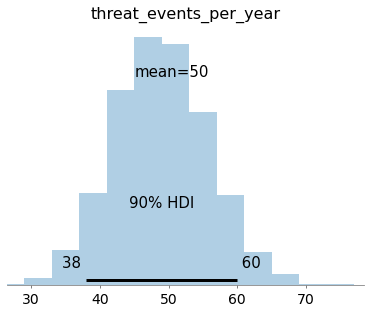

In [7]:
# Run the TEF Model
print("TEF Model - Threat Event Frequency")
tef_model()

***
### Vulnerability Model
***

In the FAIR model, the threat event frequency (TEF) is the probable frequency, within a given time-frame, that attacker will act in a manner that may result in loss. Vulnerability, in this simplistic model, is the proportion of threat events (a.k.a. attacks) that succeed. For Vulnerability, which must be between 0 and 1, I'll use a Beta distribution, Beta(1.05,10), which gives a mean≈0.1 and standard deviation ≈0.09.

In [8]:
# Vulnerability Model
def vulnerability_model():
    with pm.Model() as model:
        # Model vulnerability as a beta distribution
        vulnerability = pm.Beta('vulnerability', alpha=1.05, beta=10)

    with model:
        trace_vulnerability = pm.sample(NUM_SAMPLES, tune=1000)

    # Plot the results
    pm.plot_posterior(trace_vulnerability, var_names=['vulnerability'], hdi_prob=CONFIDENCE_INTERVAL)
    plt.show()

    # Calculate mean and standard deviation
    samps = trace_vulnerability['vulnerability']
    mean = np.mean(samps)
    sd = np.std(samps)

    print("Mean = {:.4f}; SD = {:.4f}".format(mean, sd))


Vulnerability Model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vulnerability]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8819333361920066, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.


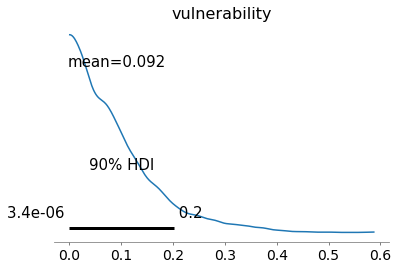

Mean = 0.0916; SD = 0.0810


In [9]:
# Run the Vulnerability Model
print("\nVulnerability Model")
vulnerability_model()

***
### Loss Event Frequency (LEF) Model
***

Next let's combine these to create a model for the loss even frequency. Assuming for each threat event (a.k.a. attack) that it will either succeed or fail, but without a fractional success in this simplified model. To implement this, we initially draw a value for the number of threat events in a simulated year from a distribution. Subsequently, we perform biased coin flips (Bernoulli trials) that many times, where the probability of "heads" (success) is drawn from the vulnerability distribution.

It seems that the Bernoulli distribution in PyMC3 doesn't play well with certain NumPy or Theano configurations. 
To work around this, I used the `pm.Binomial` directly used to model the number of successes in `threat_events` trials, which essentially represents a Bernoulli distribution.        


In [1]:
# Loss Event Frequency Model
def loss_event_frequency_model():

    with pm.Model() as model:
        # Model threat events per year as a Poisson distribution
        threat_events = pm.Poisson('threat_events', mu=1)

        # Model vulnerability as a beta distribution
        vulnerability = pm.Beta('vulnerability', alpha=1.05, beta=10)
        
        # Failing to model trials as Bernoulli trials based on threat events and vulnerability
#         trials = pm.Bernoulli('trials', p=vulnerability, shape=threat_events).astype(int)

        # Model trials as Binomial trials based on threat events and vulnerability, as a simplified version of the above
        trials = pm.Binomial('trials', n=threat_events, p=vulnerability)


        # Count the number of successes in the trials
        successes = pm.math.sum(trials)

        # Observed variable for the loss event frequency
        loss_event_frequency = pm.Deterministic('loss_event_frequency', pm.math.sum(successes))

    with model:
        trace = pm.sample(NUM_SAMPLES)

    return model, trace

In [11]:
# Run the Loss Event Frequency Model
print("Loss Event Frequency Model")
model1, trace1 = loss_event_frequency_model()

Loss Event Frequency Model


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [trials]
>>Metropolis: [threat_events]
>NUTS: [vulnerability]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.


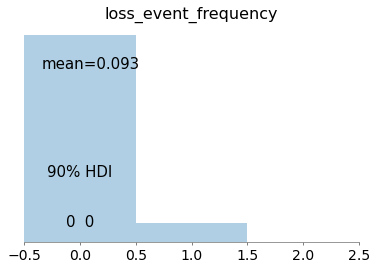

In [12]:
# Plot the results
pm.plot_posterior(trace1, var_names=['loss_event_frequency'], hdi_prob=CONFIDENCE_INTERVAL)
plt.show()

***
### Loss Magnitude (LM) Model
***

Switching to Loss Magnitude, I'll attempt to model primary and secondary losses separately. I think the ideas are right, but this is not the best way to combine them. We know that losses are lognormal distributed, and we know the log loss mean per industry and organization revenur and size, so the primary losses are at half (an assumption to be discussed in a real world scenario).

In this code:

- `pm.Lognormal` is used to model the magnitude as a log-normal distribution.
- The mu parameter is set to half and the sigma parameter is set to half.
- The shape parameter is used to specify the number of samples.


In [13]:
# Primary Loss Model
def primary_loss_model():

    with pm.Model() as model:
        # Model magnitude as a log-normal distribution
        magnitude = pm.Lognormal('magnitude', mu=np.log(LOG_MEAN/2), sigma=np.log(LOG_STD), shape=NUM_SAMPLES)

    with model:
        trace = pm.sample(NUM_SAMPLES, tune=1000)
    return model, trace

In [14]:
# Run the Primary Loss Model
print("Primary Loss Probability Density Function")
model, trace = primary_loss_model()

Primary Loss Probability Density Function


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [magnitude]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.


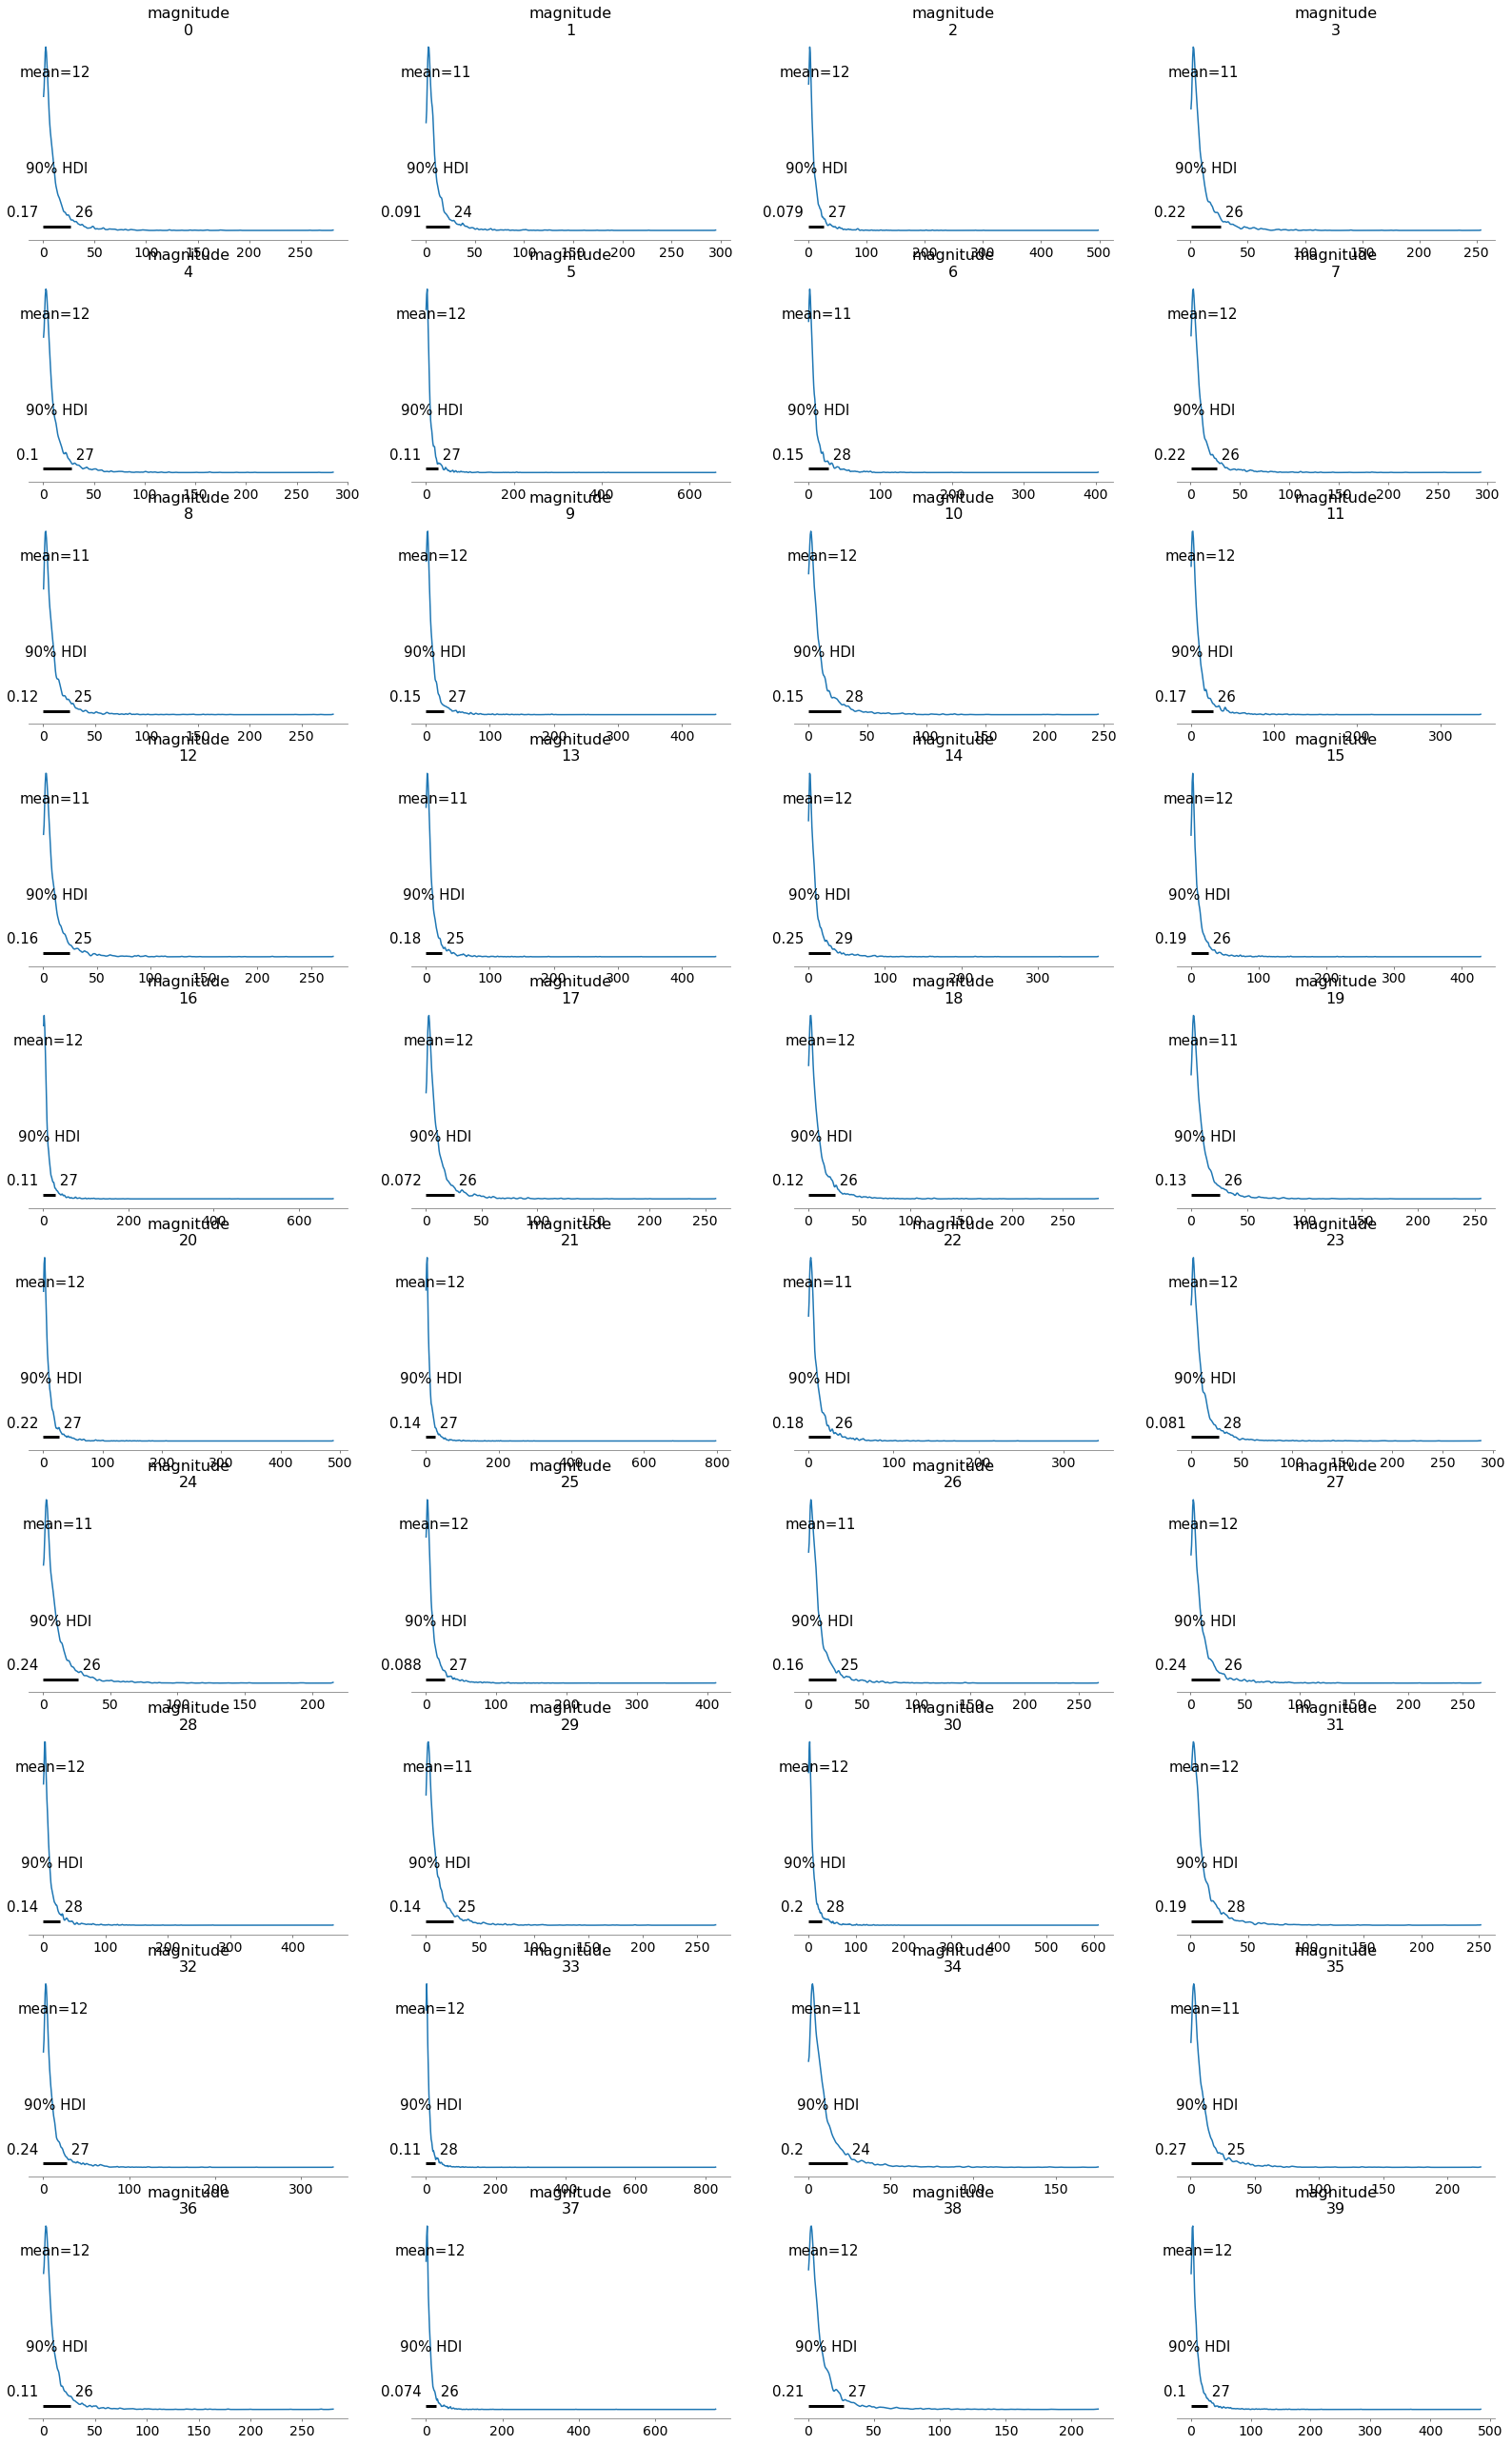

In [15]:
# Plot the results
pm.plot_posterior(trace, var_names=['magnitude'], hdi_prob=CONFIDENCE_INTERVAL)
plt.show()

The secondary loss is a conditional probabilistic loss. For some events there is no secondary loss, but there is a certain probability that there will be a secondary loss, which is drawn from a distribution – we’ll assume it is lognormal. 

In [16]:
# Secondary Risk Model
def secondary_loss_model():

    with pm.Model() as model:
        # Model trigger as a Bernoulli distribution
        trigger = pm.Bernoulli('trigger', p=.01, shape=NUM_SAMPLES)

        # Model loss as a mixture of log-normal and point mass at 0
        magnitude = pm.math.switch(trigger, pm.Lognormal('magnitude', mu=np.log(LOG_MEAN), sigma=np.log(2*LOG_STD), shape=NUM_SAMPLES), 0)

    with model:
        trace = pm.sample(NUM_SAMPLES, tune=1000)
    return model, trace

In [17]:
# Run the Secondary Risk Model
print("Secondary Risk Probability Density Function")
model, trace = secondary_loss_model()

Secondary Risk Probability Density Function


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [trigger]
>NUTS: [magnitude]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.


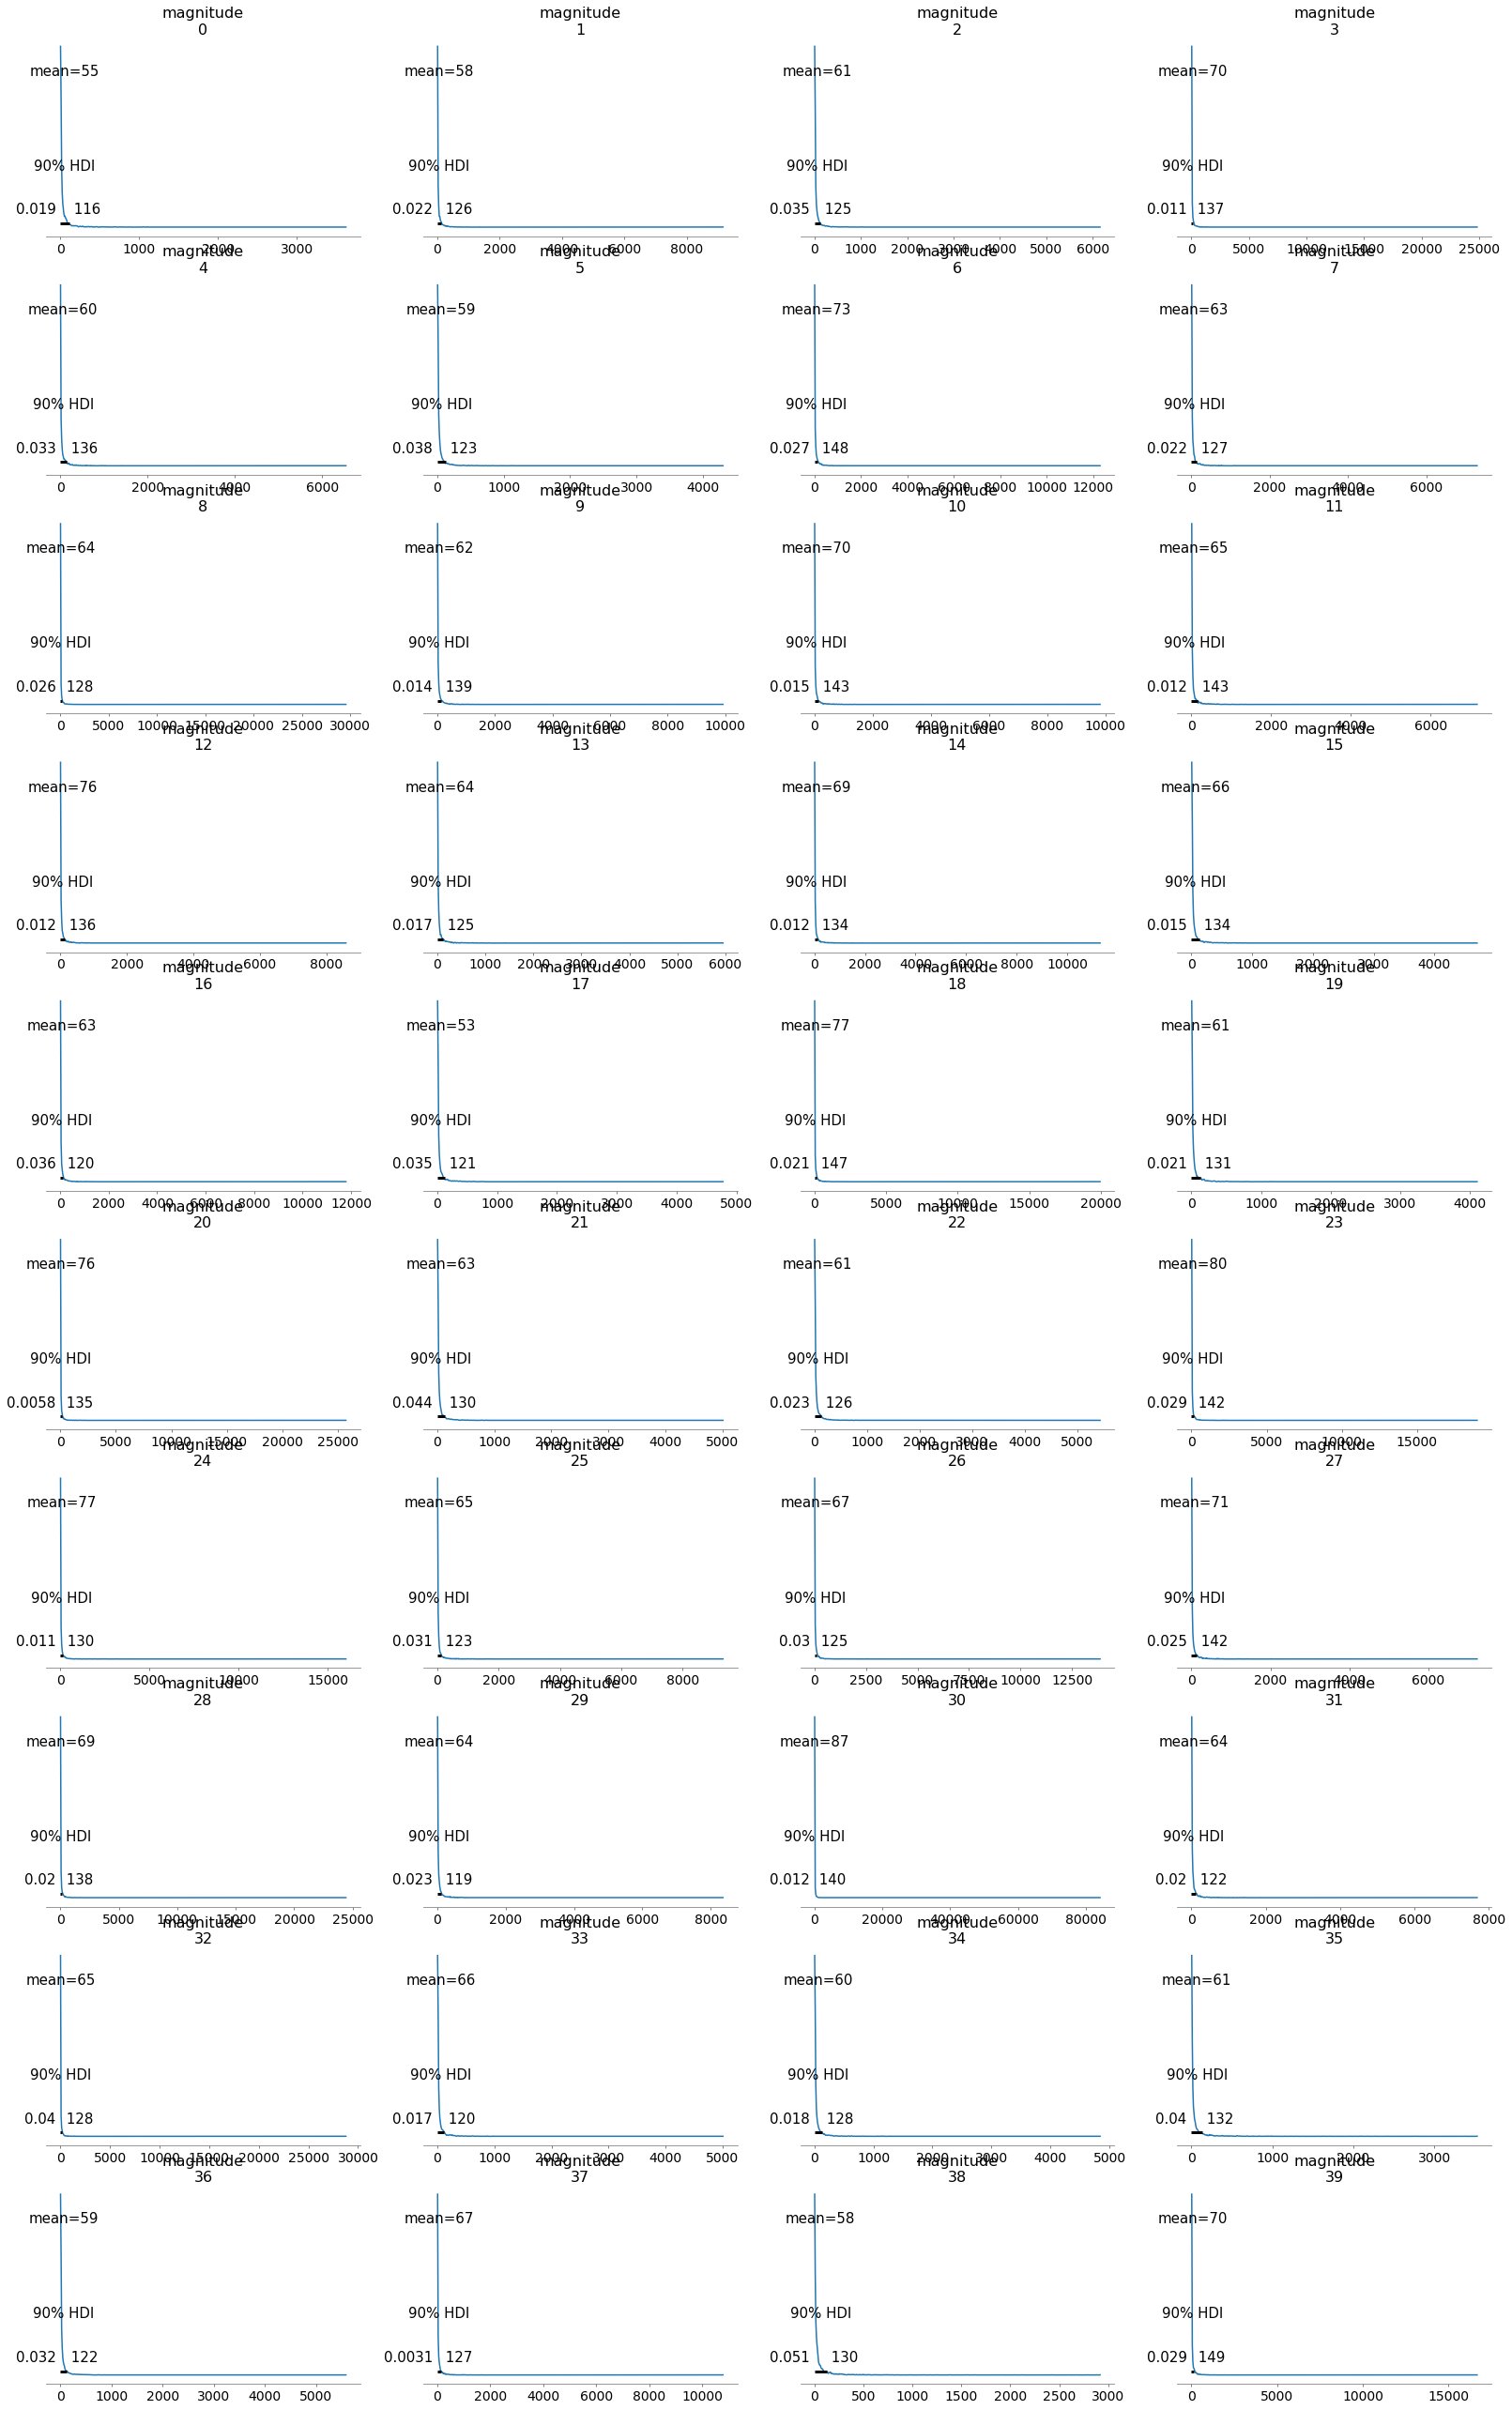

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


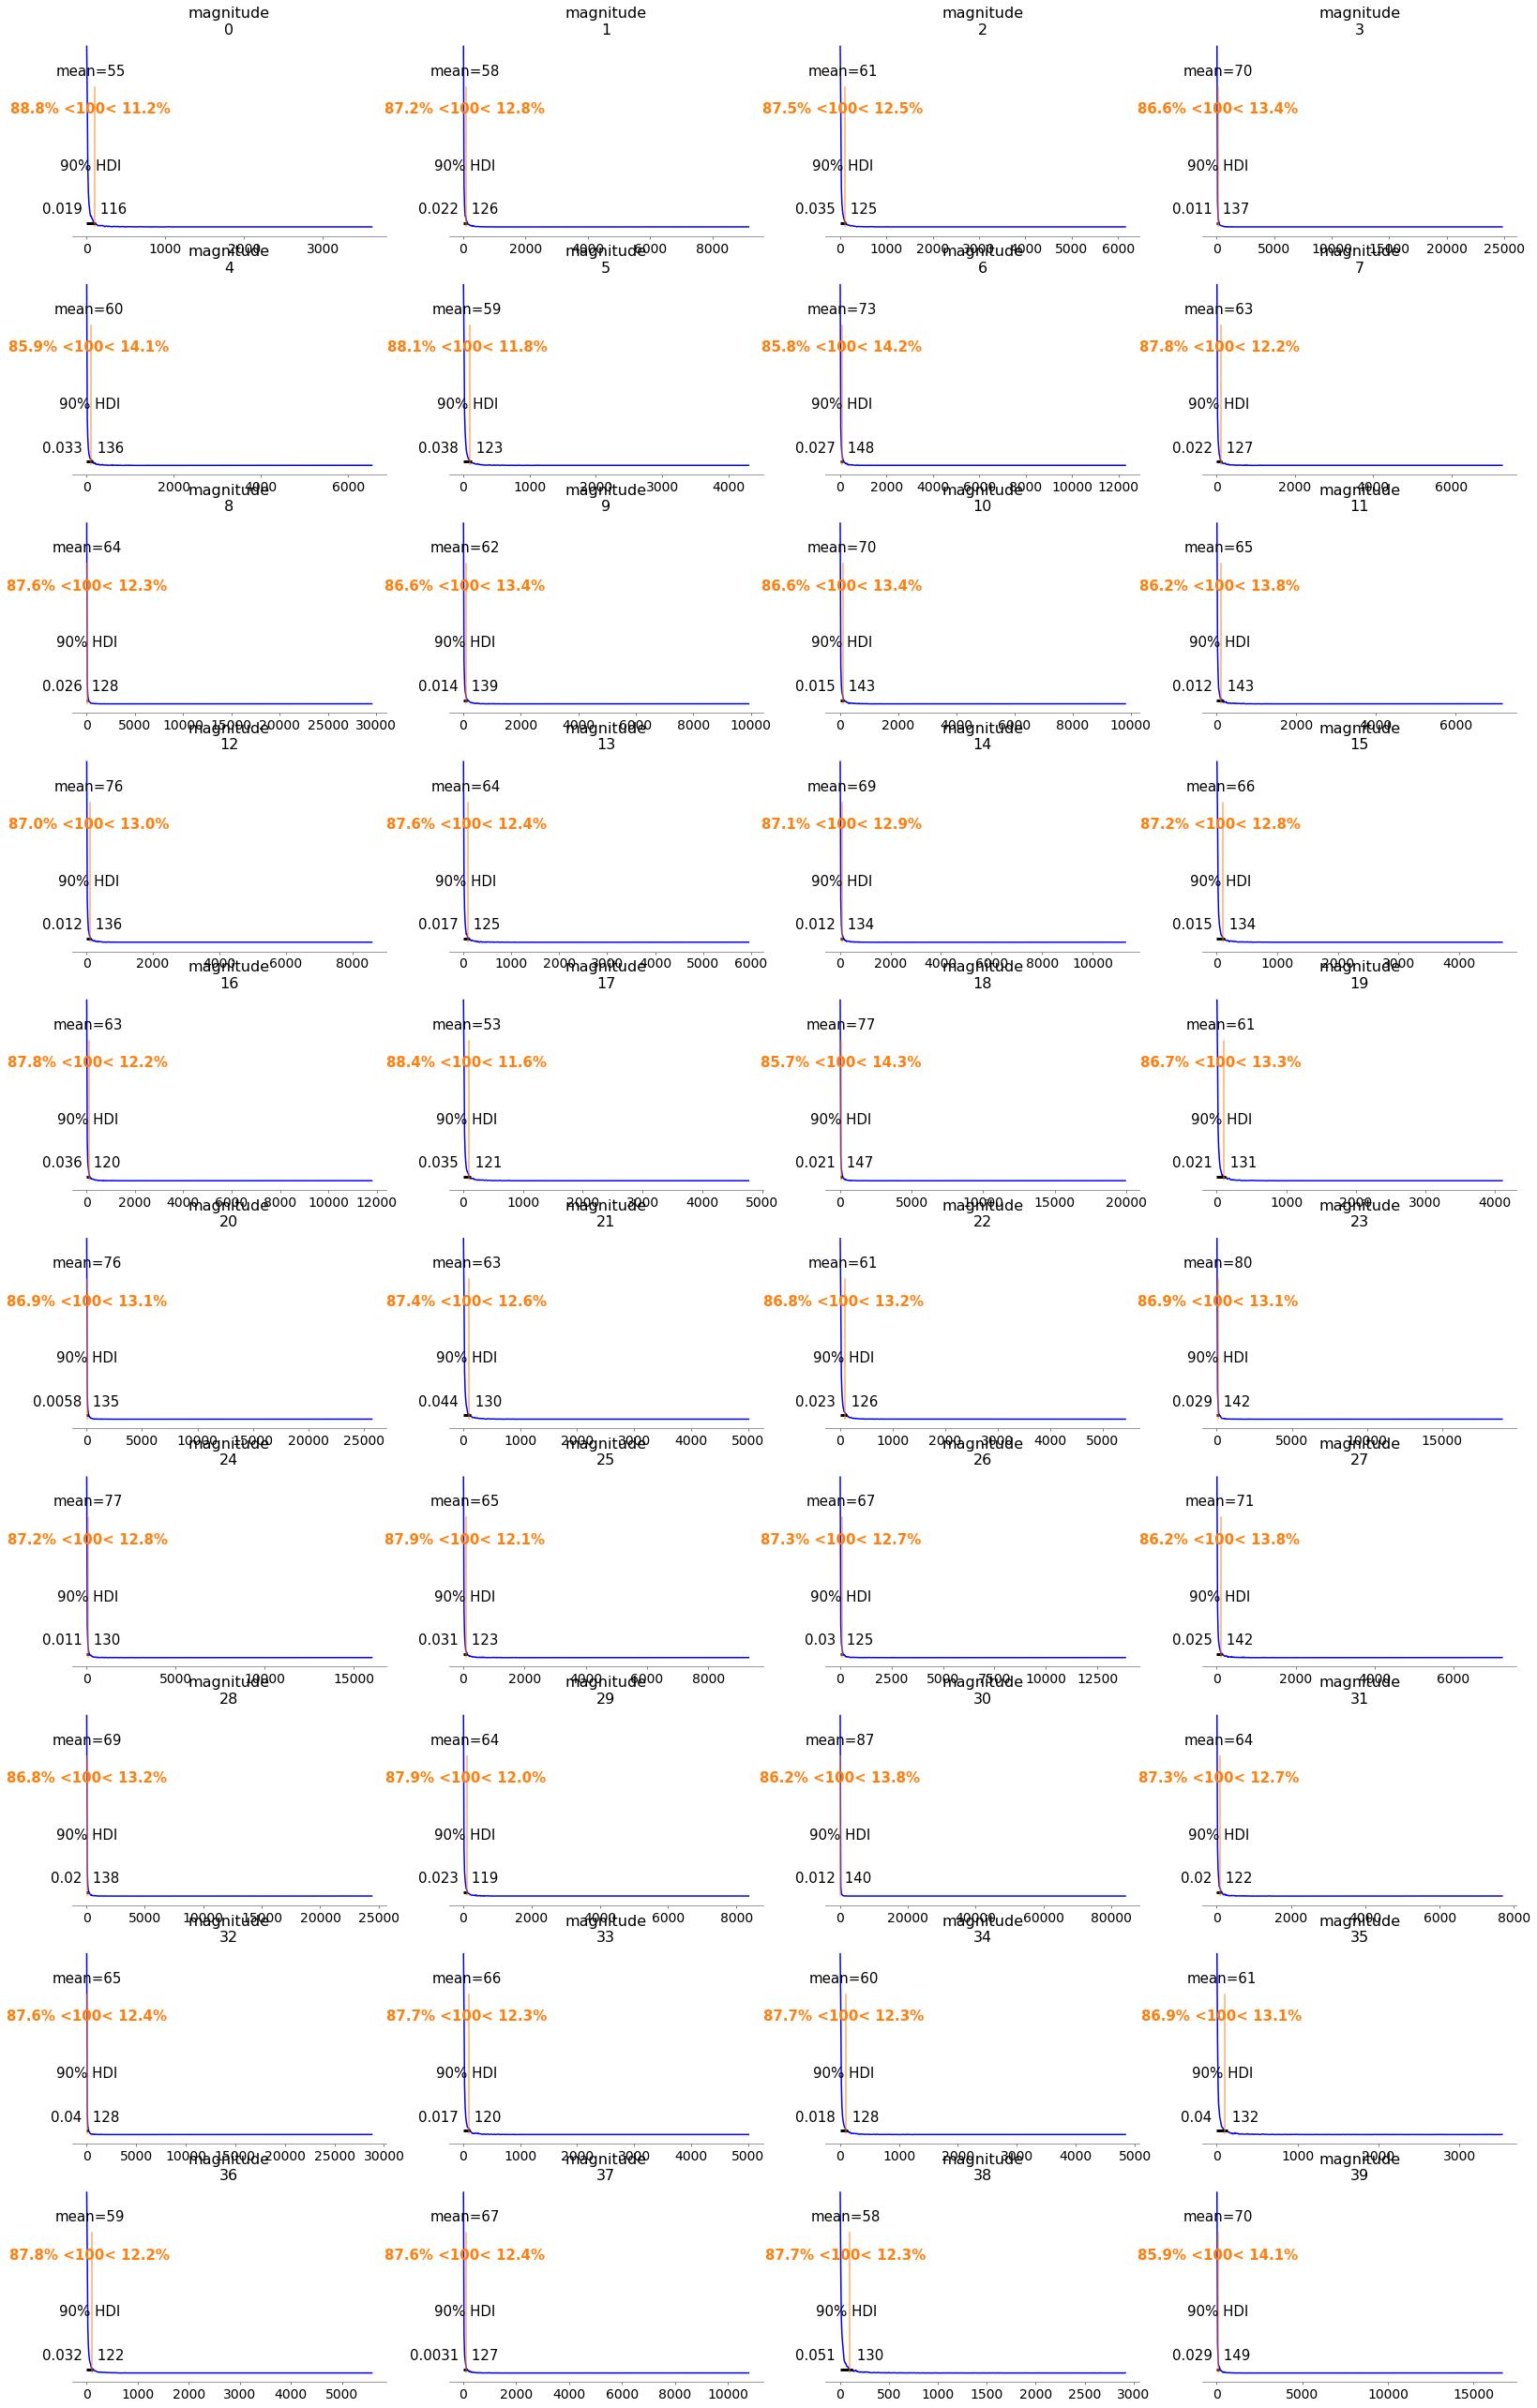

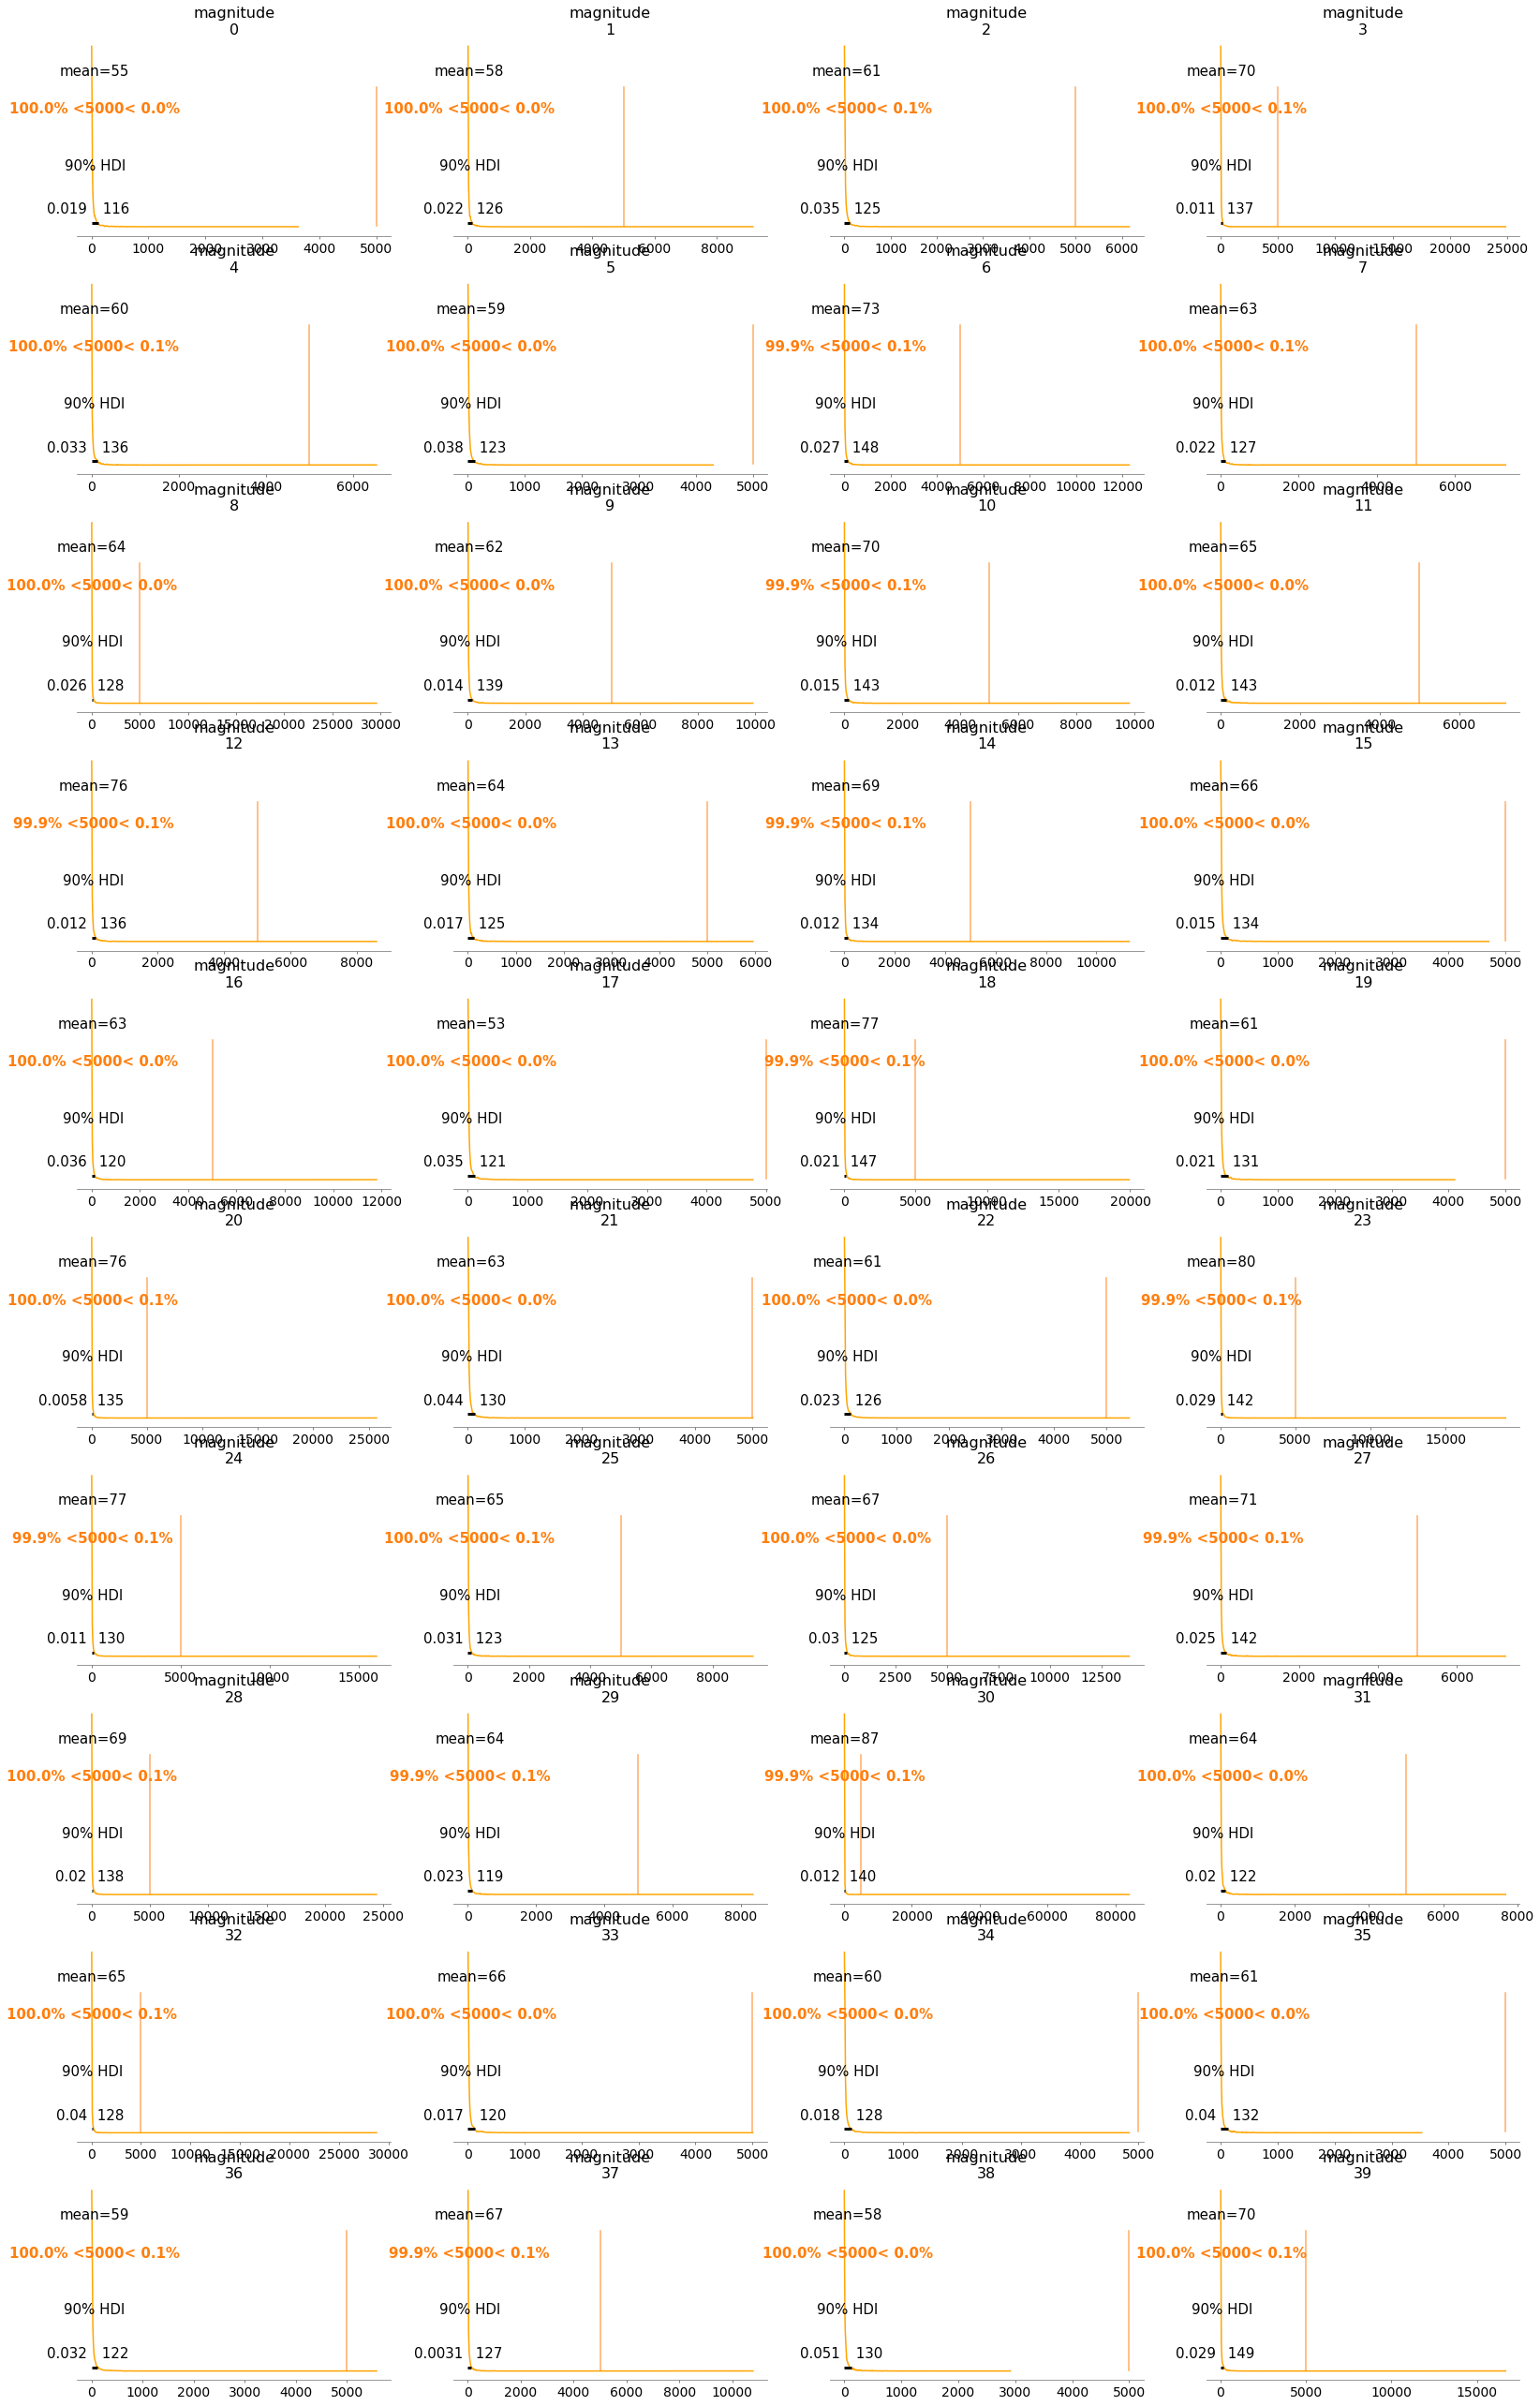

In [18]:
# Plot the results
pm.plot_posterior(trace, var_names=['magnitude'], hdi_prob=CONFIDENCE_INTERVAL)
plt.show()

# Plot density within specified bounds
pm.plot_posterior(trace, var_names=['magnitude'], hdi_prob=CONFIDENCE_INTERVAL, ref_val=100, color='blue', kind='kde')
pm.plot_posterior(trace, var_names=['magnitude'], hdi_prob=CONFIDENCE_INTERVAL, ref_val=5000, color='orange', kind='kde')
plt.show()

This code models the loss magnitude as the sum of primary and secondary losses, where each loss is sampled from a log-normal distribution or set to 0 based on the trigger. 

In [19]:
# Loss Magnitude Model
def loss_magnitude_model():

    with pm.Model() as model:
        # Model primarily loss as a log-normal distribution
        primary_loss = pm.Lognormal('primary_loss', mu=np.log(LOG_MEAN/2), sigma=np.log(LOG_STD), shape=NUM_SAMPLES)

        # Model trigger for secondary risk as a Bernoulli distribution
        trigger = pm.Bernoulli('trigger', p=0.4, shape=NUM_SAMPLES)

        # Model secondary risk loss as a mixture of log-normal and point mass at 0
        secondary_loss = pm.math.switch(trigger, pm.Lognormal('secondary_loss', mu=np.log(LOG_MEAN), sigma=np.log(2*LOG_STD), shape=NUM_SAMPLES), 0)

        # Total loss magnitude as the sum of primarily and secondary losses
        loss_magnitude = pm.Deterministic('loss_magnitude', primary_loss + secondary_loss)

    with model:
        trace = pm.sample(NUM_SAMPLES, tune=1000)
    return model, trace

In [20]:
# Run the Loss Magnitude Model
print("Loss Magnitude Probability Density")
model2, trace2 = loss_magnitude_model()

Loss Magnitude Probability Density


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [secondary_loss, primary_loss]
>BinaryGibbsMetropolis: [trigger]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 126 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.


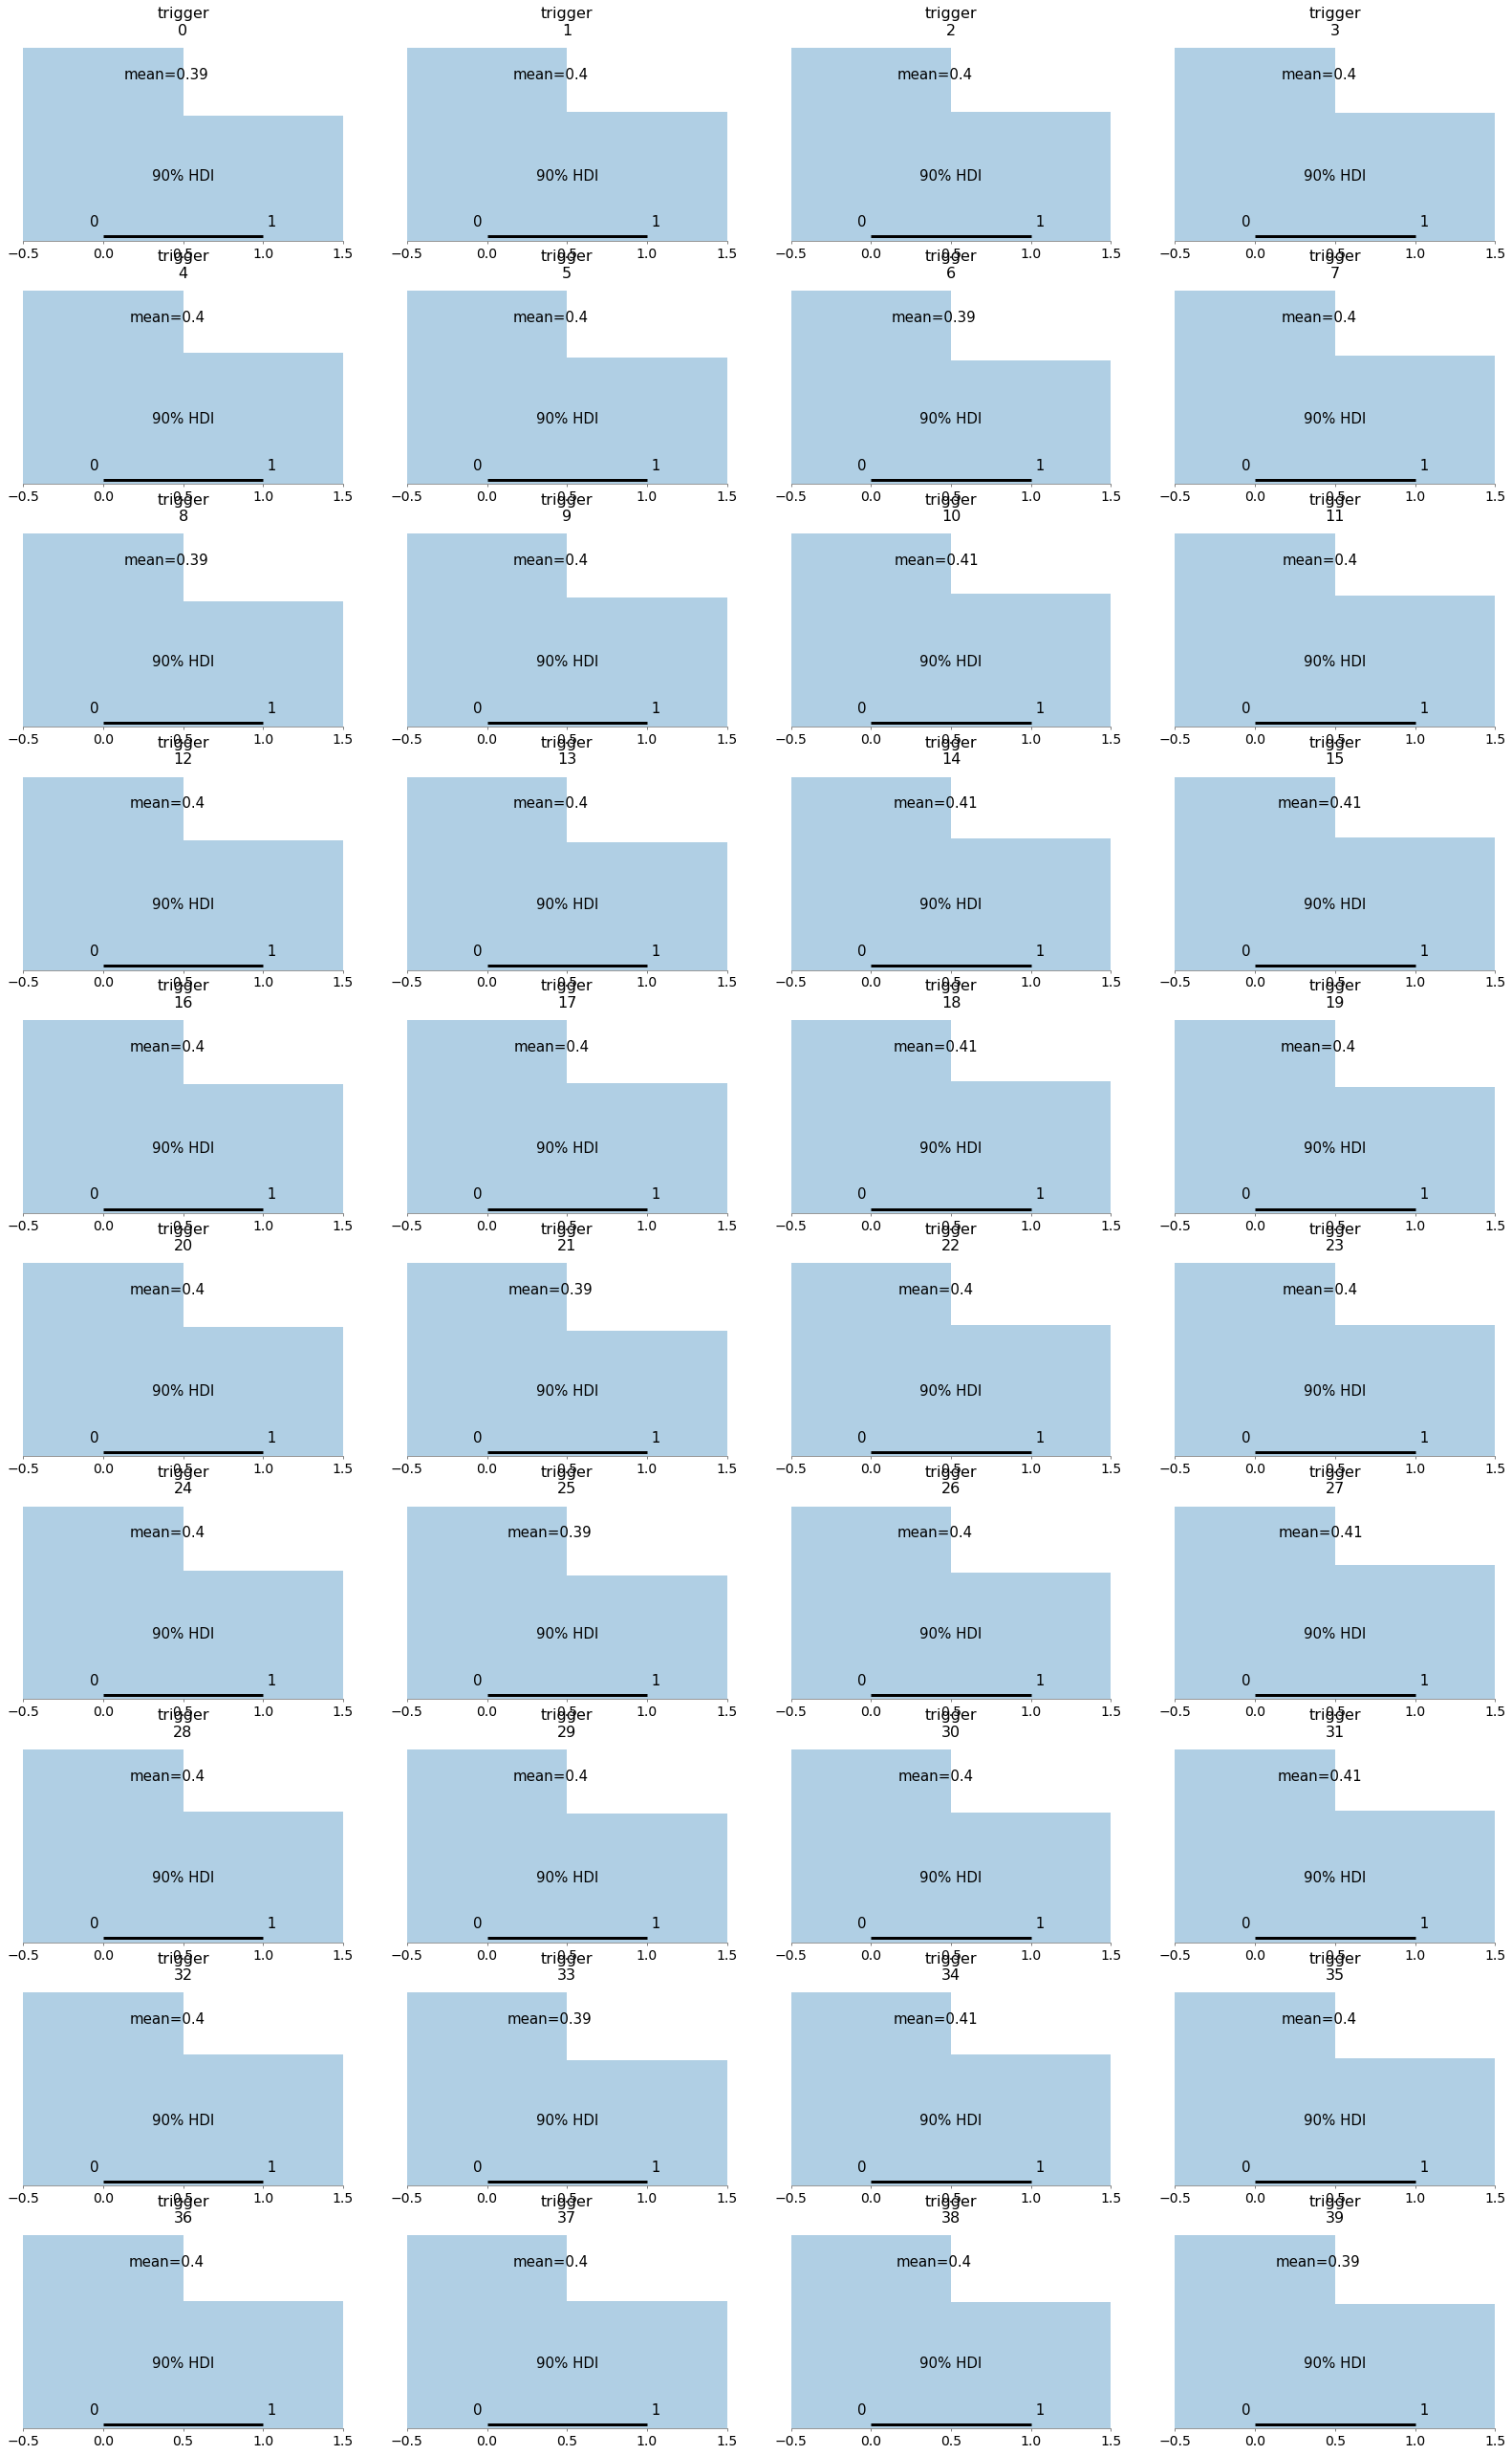

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


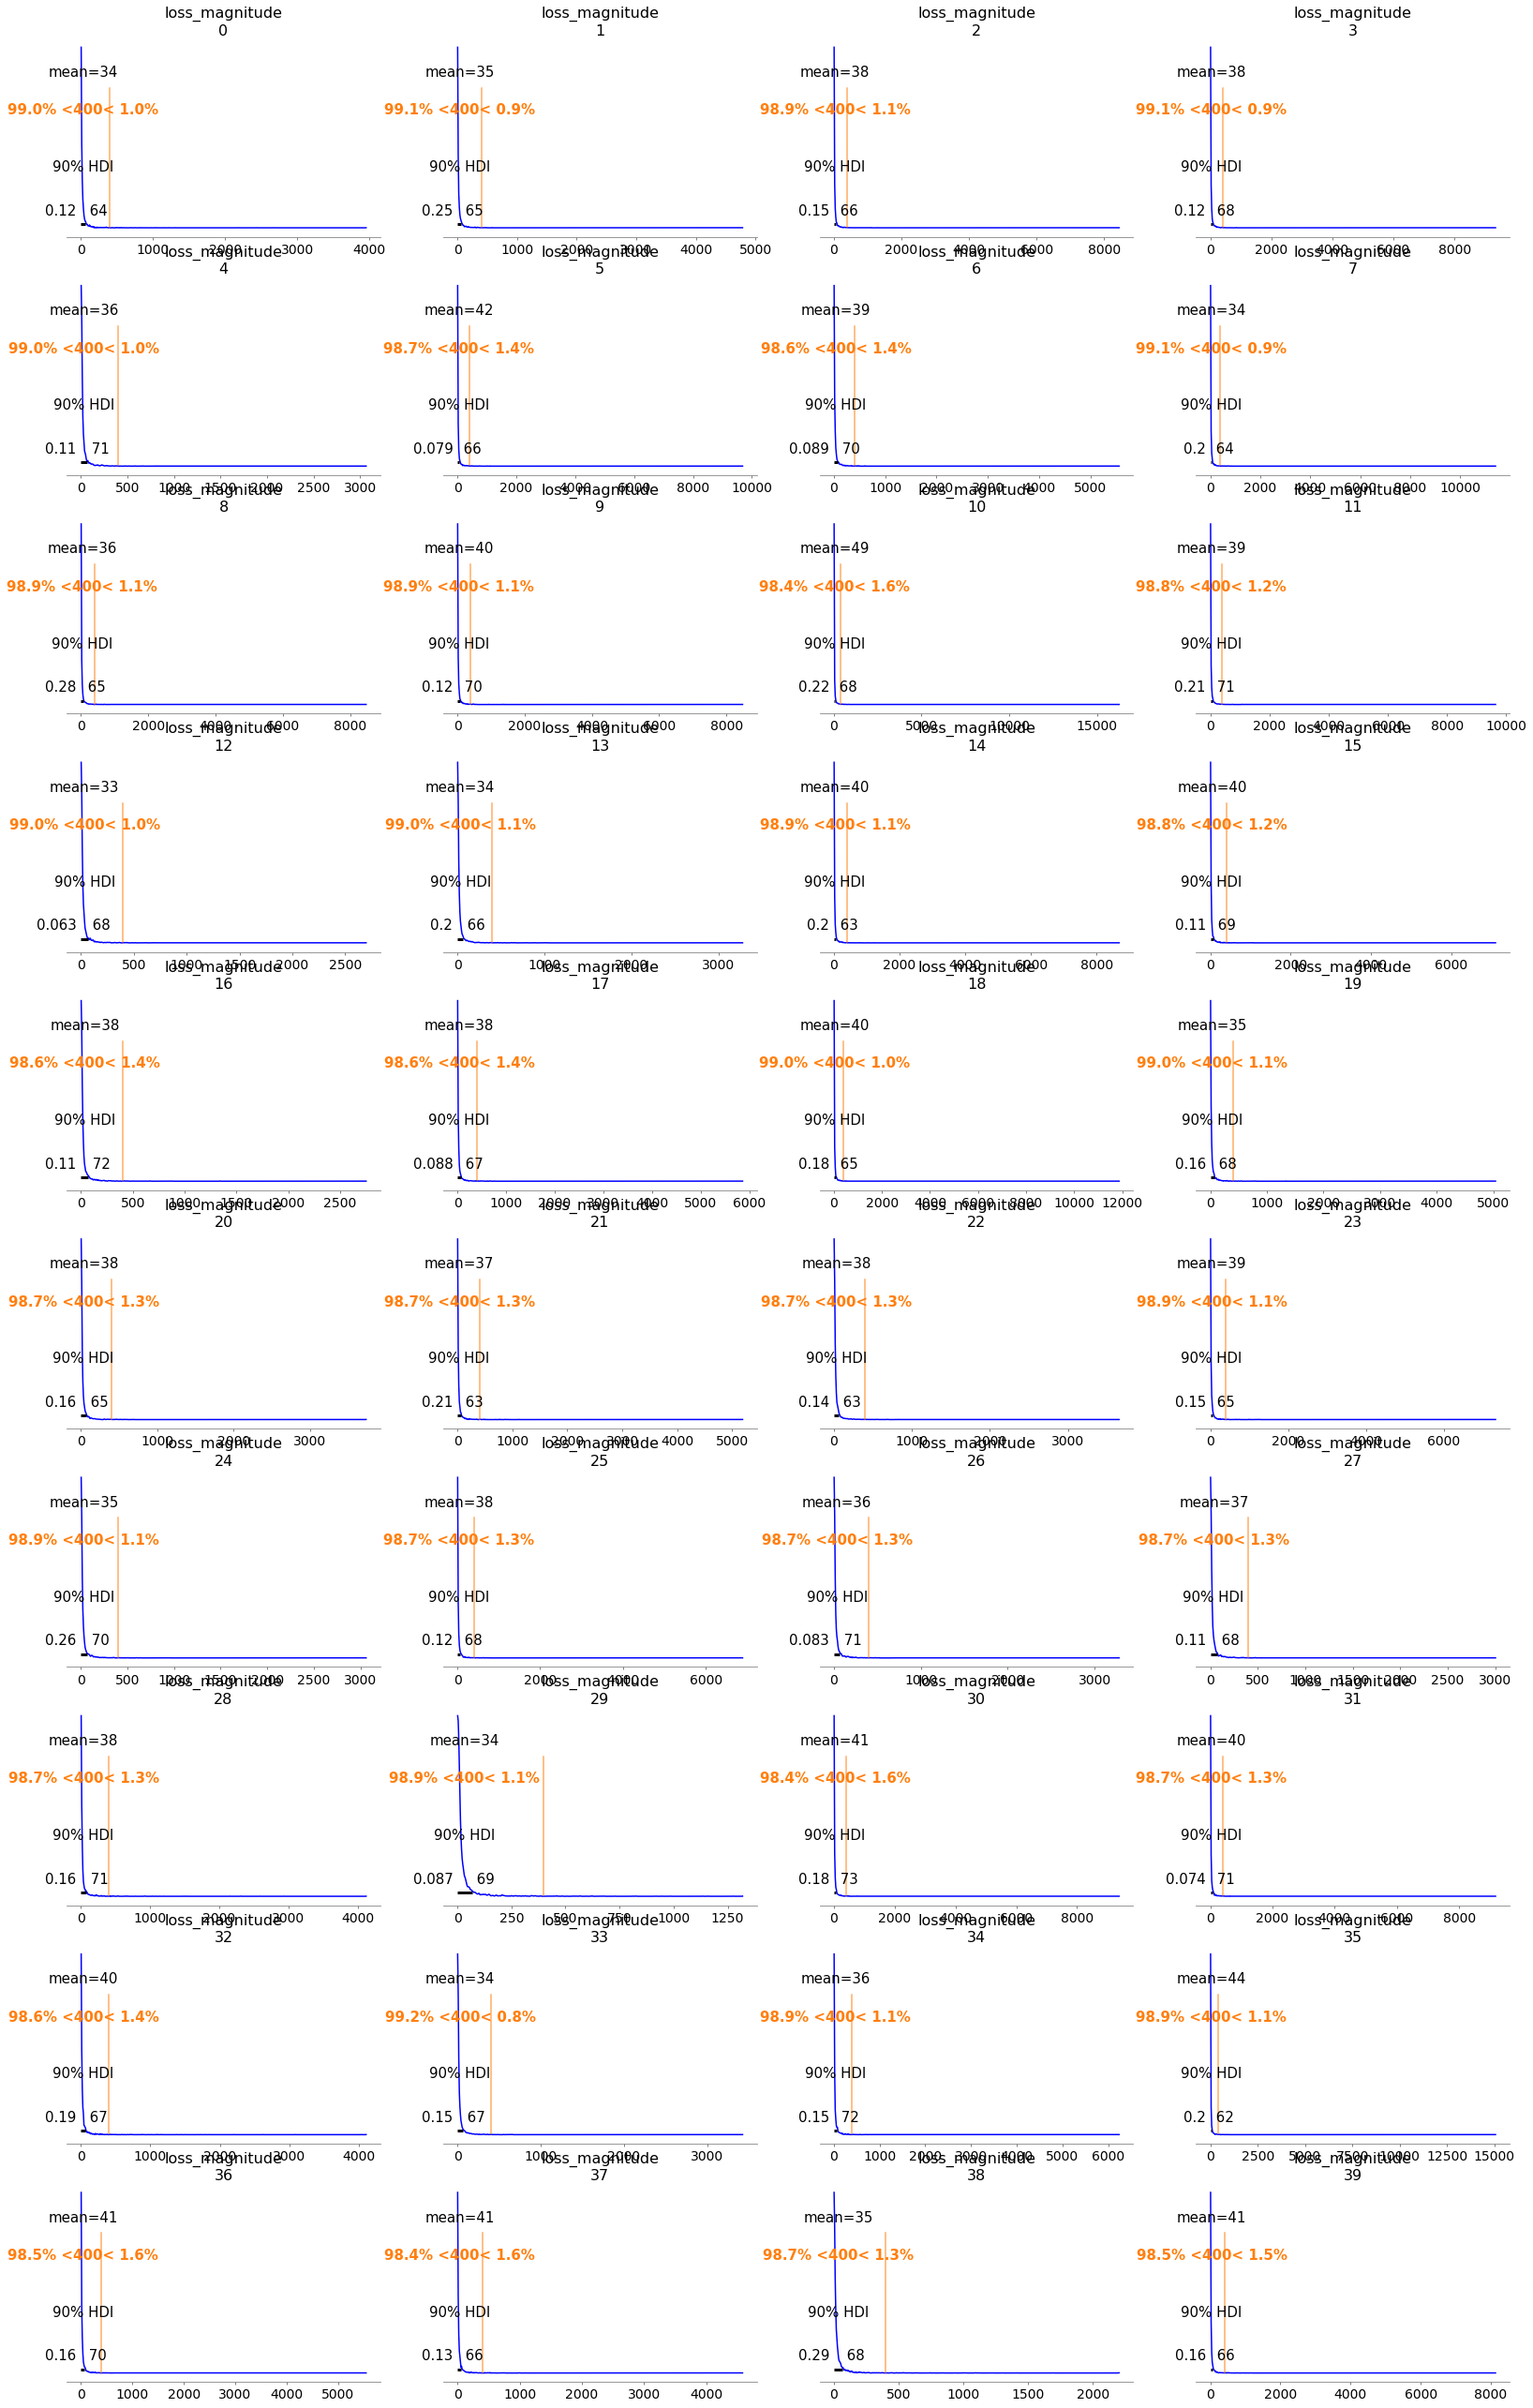

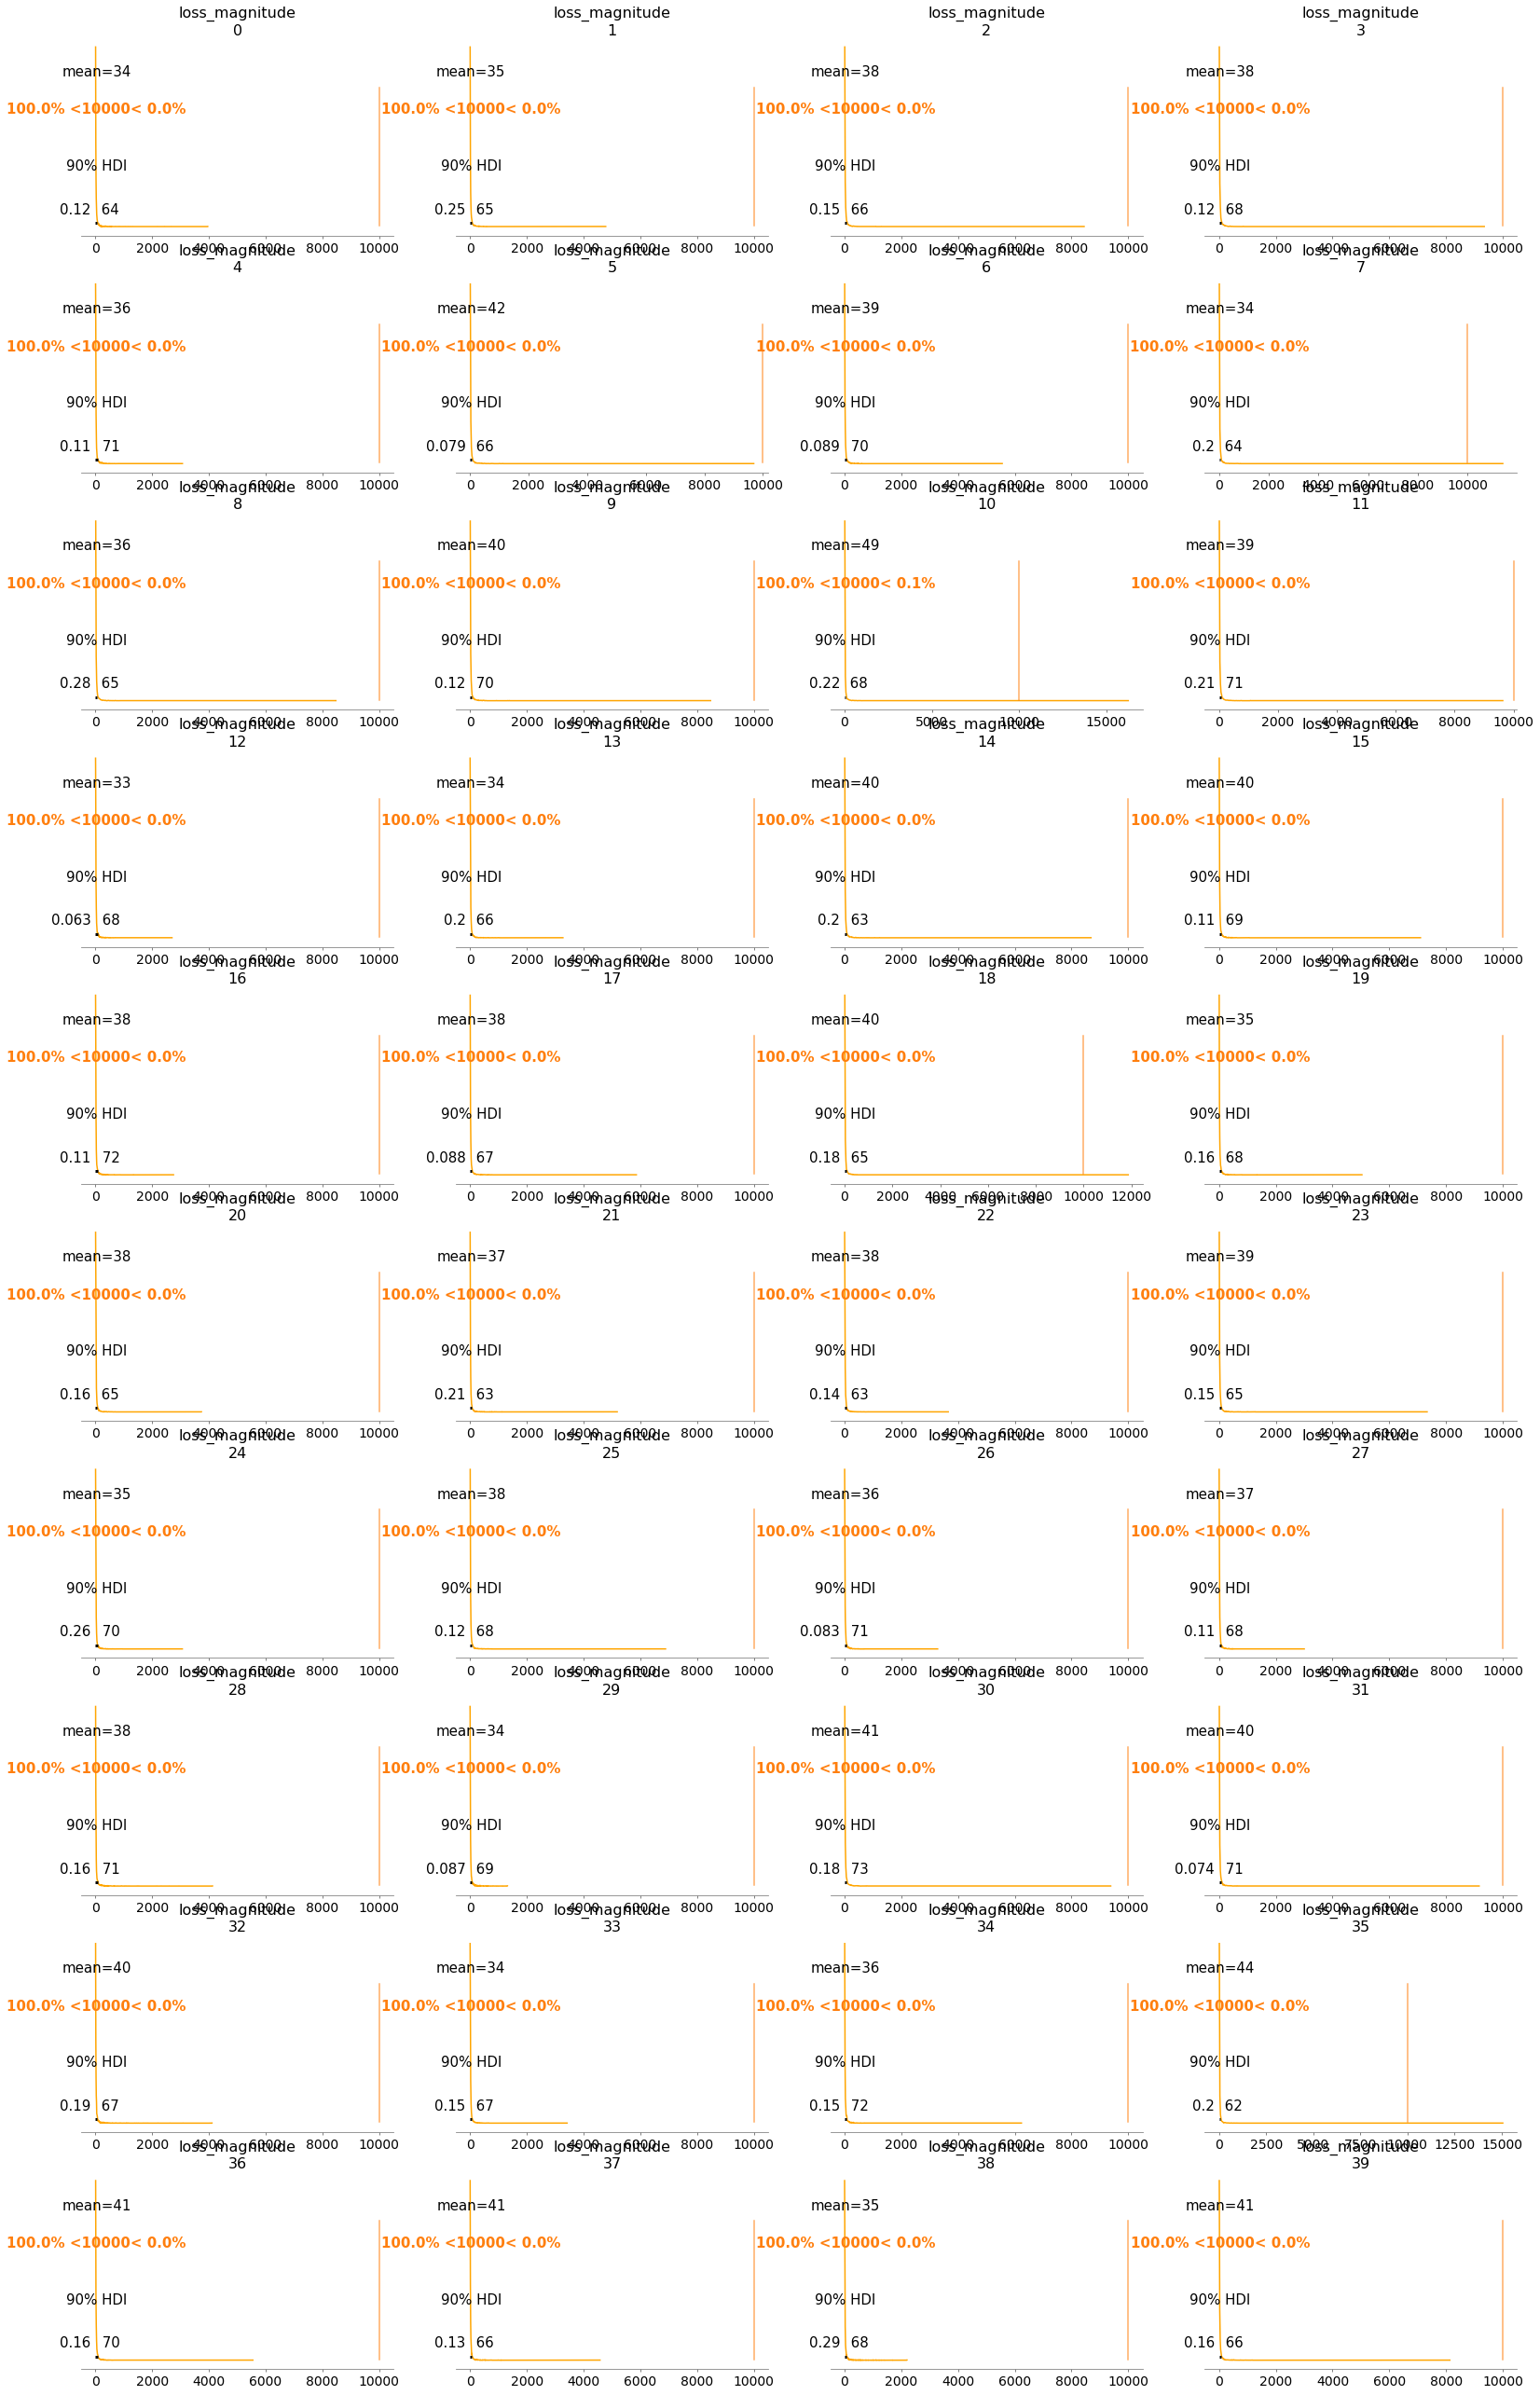

In [21]:
# Plot the results
pm.plot_posterior(trace2, hdi_prob=CONFIDENCE_INTERVAL)
plt.show()

# Plot density within specified bounds
pm.plot_posterior(trace2, var_names=['loss_magnitude'], hdi_prob=CONFIDENCE_INTERVAL, ref_val=400, color='blue', kind='kde')
pm.plot_posterior(trace2, var_names=['loss_magnitude'], hdi_prob=CONFIDENCE_INTERVAL, ref_val=10000, color='orange', kind='kde')
plt.show()

***
### Risk Model
***

In [22]:
def risk_model(loss_magnitude_trace, loss_freq_trace):
    # Add a stochastic variable
    theta = pm.Normal('theta', mu=0, sigma=.1)

    # Extract values from the traces
    loss_event_frequency_values = loss_freq_trace['loss_event_frequency']
    loss_magnitude_values = loss_magnitude_trace['loss_magnitude']

    # Calculate risk as the dot product of frequency and loss
    risk = pm.Deterministic('risk', pm.math.dot(loss_event_frequency_values, loss_magnitude_values) + theta)

    return risk

In [23]:
with pm.Model() as model:
    risk = risk_model(trace2, trace1)
    
    # Sample from the model
    trace_risk = pm.sample(NUM_SAMPLES, tune=2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [24]:
# Print risk probability density
az.summary(trace_risk, var_names=['risk'], hdi_prob=CONFIDENCE_INTERVAL)

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
risk[0],14922.265,0.1,14922.093,14922.414,0.005,0.003,455.0,677.0,NaN
risk[1],9428.692,0.1,9428.520,9428.842,0.005,0.003,455.0,677.0,NaN
risk[2],16968.861,0.1,16968.689,16969.010,0.005,0.003,455.0,677.0,NaN
risk[3],11575.625,0.1,11575.453,11575.775,0.005,0.003,455.0,677.0,NaN
risk[4],17582.875,0.1,17582.703,17583.025,0.005,0.003,455.0,677.0,NaN
...,...,...,...,...,...,...,...,...,...
risk[995],14299.437,0.1,14299.265,14299.587,0.005,0.003,455.0,677.0,NaN
risk[996],15692.089,0.1,15691.917,15692.239,0.005,0.003,455.0,677.0,NaN
risk[997],15875.278,0.1,15875.106,15875.427,0.005,0.003,455.0,677.0,NaN
risk[998],24232.098,0.1,24231.926,24232.248,0.005,0.003,455.0,677.0,NaN


Got error No model on context stack. trying to find log_likelihood in translation.


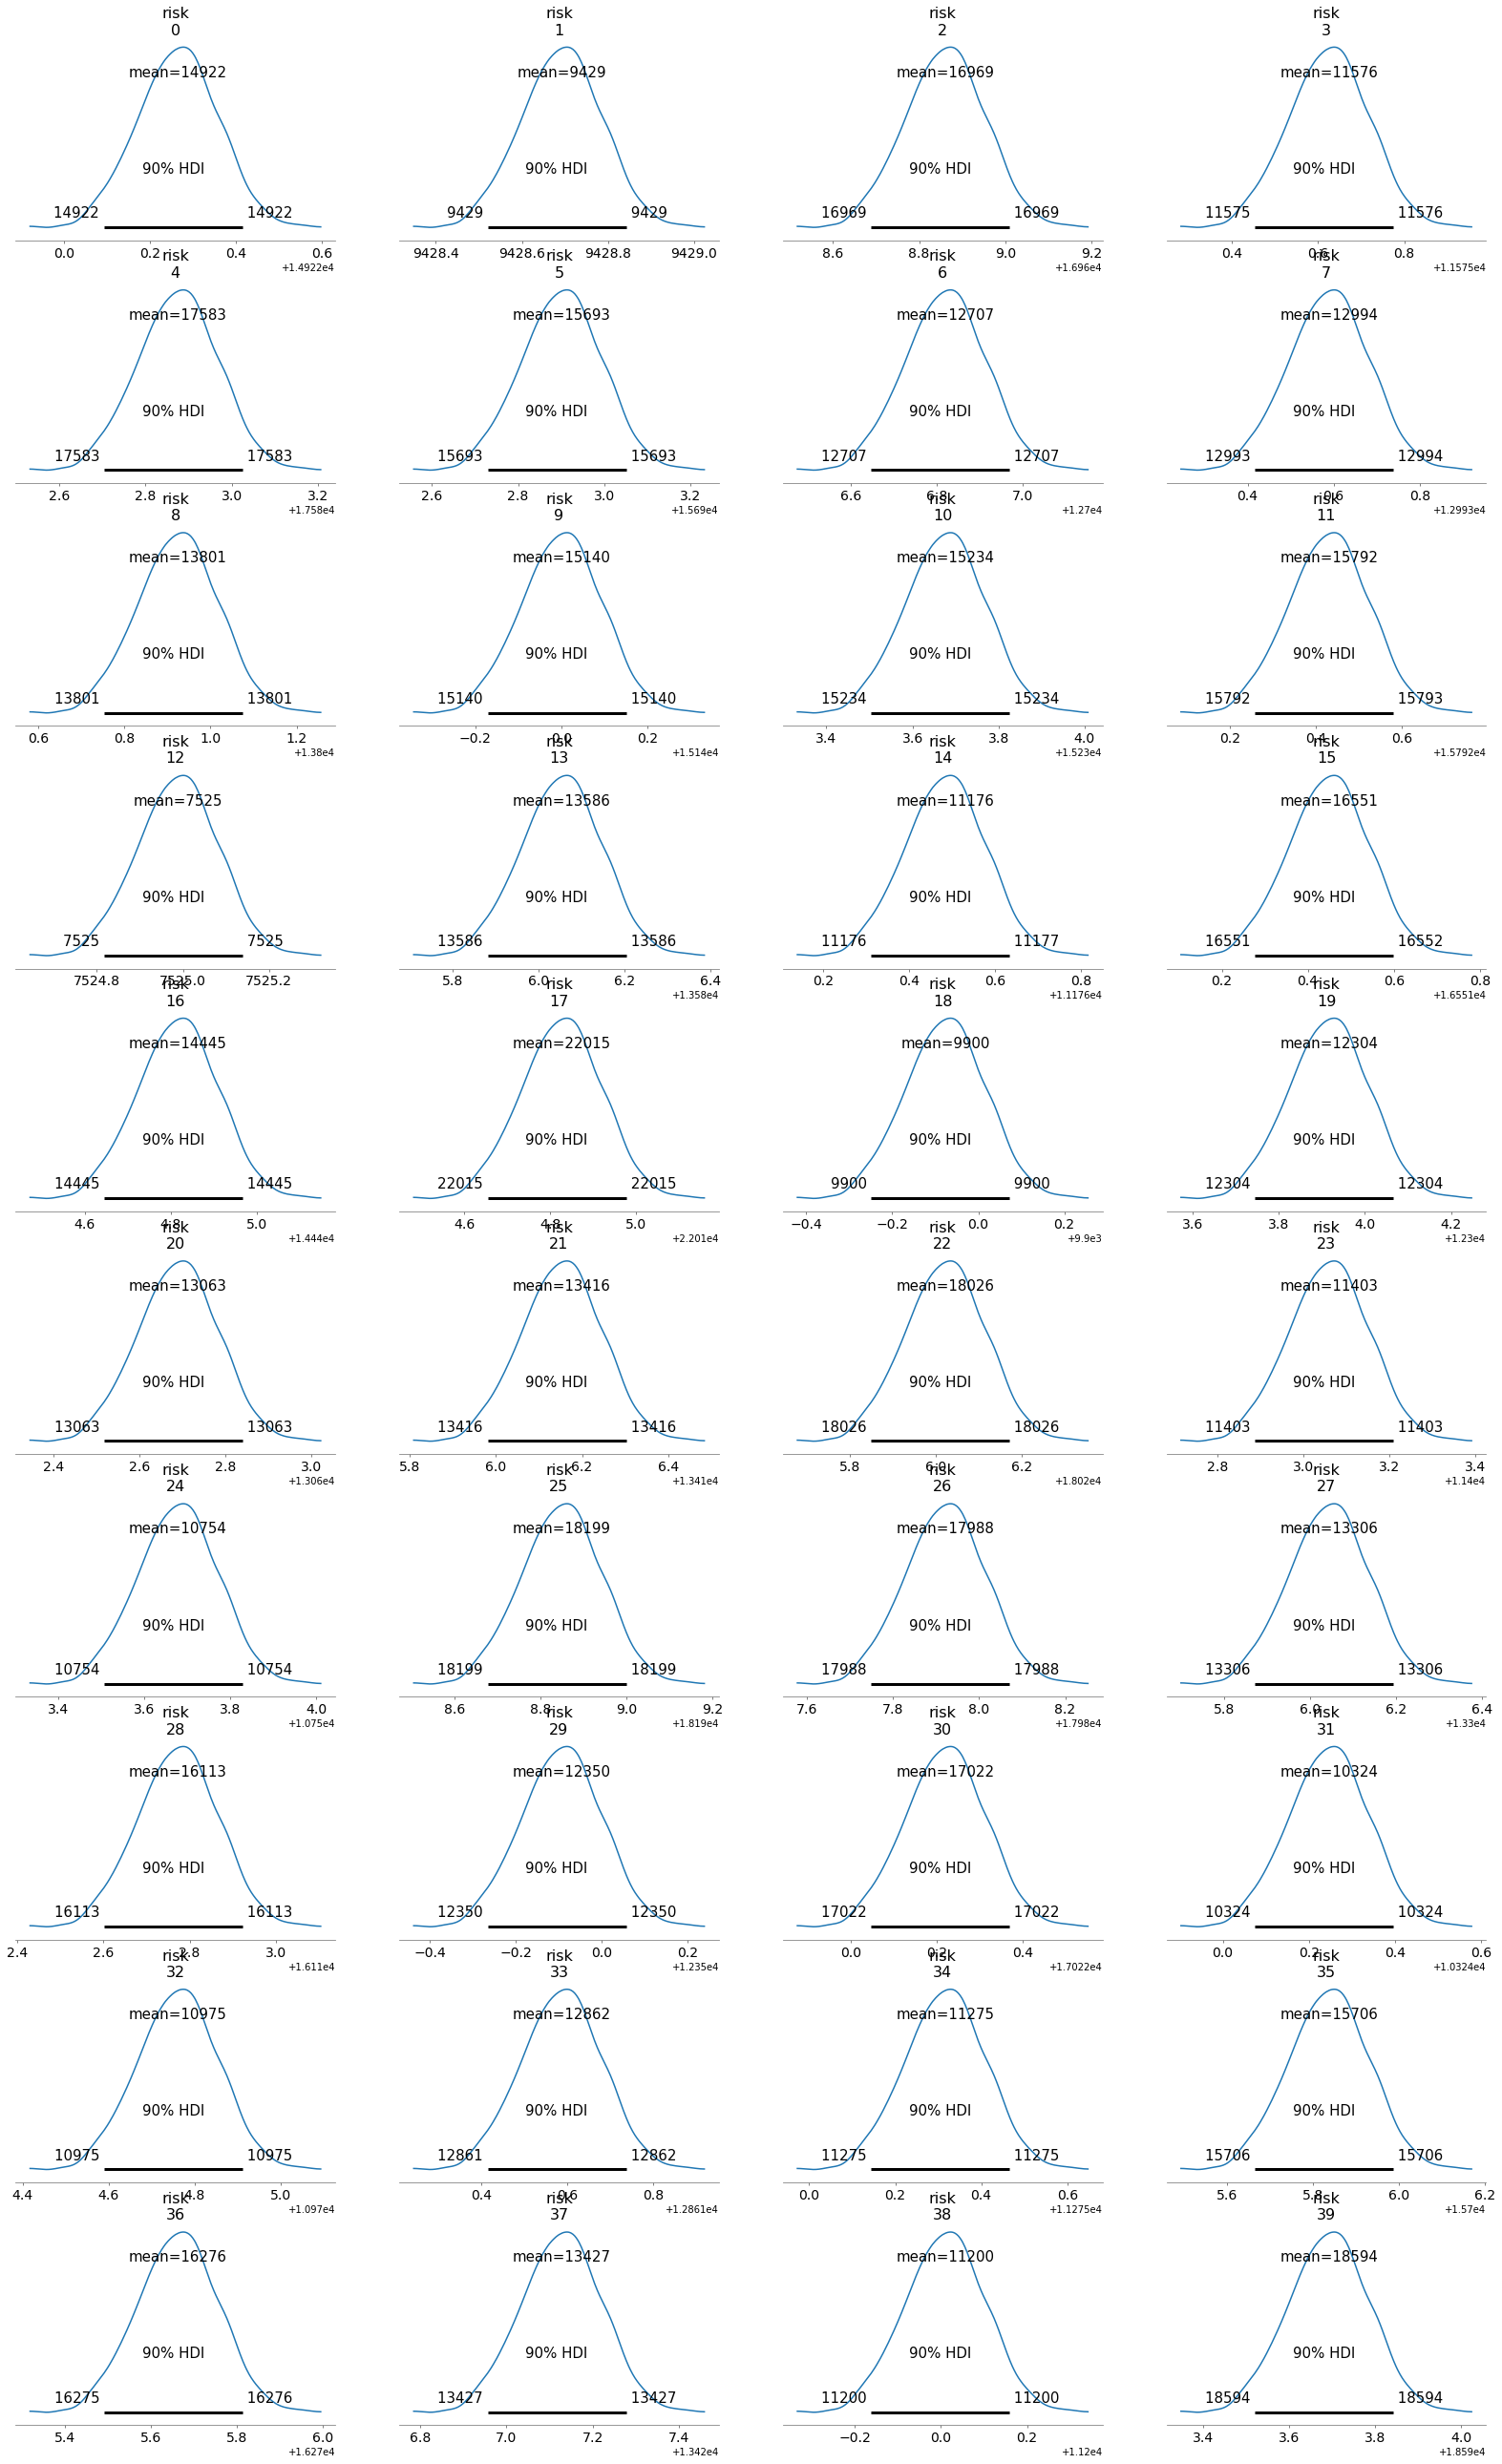

In [25]:
# Plot the results
pm.plot_posterior(trace_risk, var_names=['risk'], hdi_prob=CONFIDENCE_INTERVAL)
plt.show()